In [12]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets
import time
from torch.utils.data import DataLoader

In [13]:
from torch.utils.data import sampler

data_transforms = {
    'train': T.Compose([
          T.RandomResizedCrop(224),
          T.ColorJitter(hue=.05, saturation=.05),
          T.RandomHorizontalFlip(),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': T.Compose([
          T.Resize(256),
          T.CenterCrop(224),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

data_size = {
    'train': range(49000),
    'val': range(49000, 50000),
}

image_datasets = {x: datasets.CIFAR10('./datasets', train=True, download=True,
                                      transform=data_transforms[x]) for x in ['train', 'val']
                  }
image_dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, 
                                   sampler=sampler.SubsetRandomSampler(data_size[x]), num_workers=8) for x in ['train', 'val']
                     }
class_names = image_datasets['train'].classes
print(class_names)

device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cuda:0


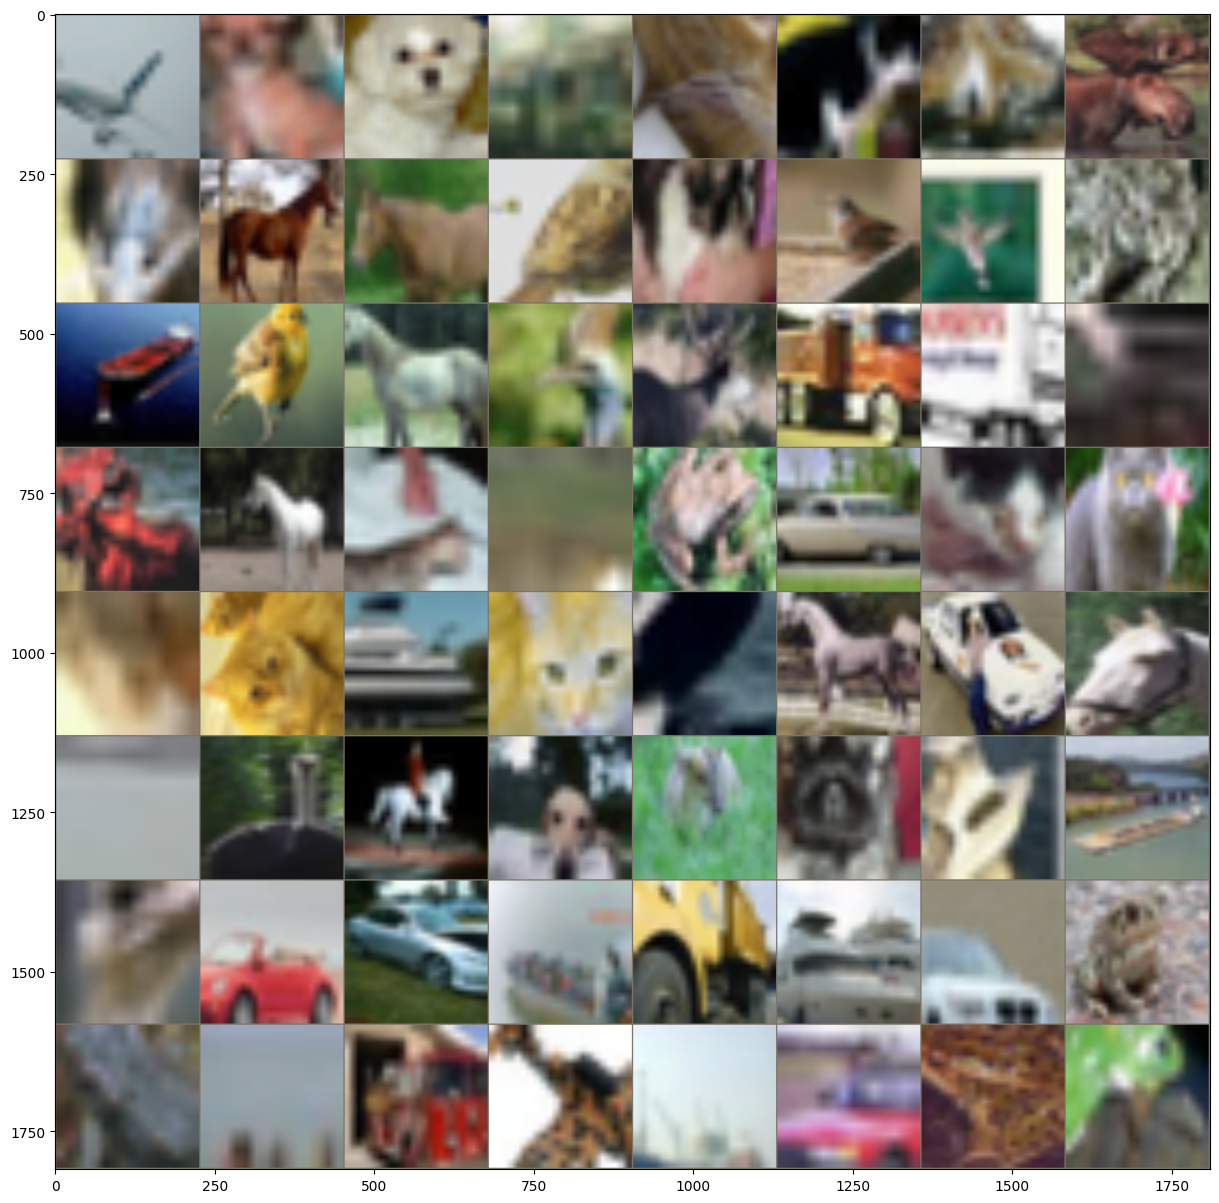

In [14]:
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)

inputs, classes = next(iter(image_dataloaders['train']))
out = torchvision.utils.make_grid(inputs, nrow=8)
fig, ax = plt.subplots(1, figsize=(15, 15))
imshow(out, ax=ax)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_val = -1
  acclist = []
  losslist = []
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() 
      else:
        model.eval()  
      
      running_loss = 0.0
      running_corrects = 0
      for i, (x, y) in enumerate(image_dataloaders[phase]):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          scores = model(x)
          loss = criterion(scores, y)
          _, preds = scores.max(1)
          
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss * x.size(0)
        running_corrects += (preds == y).sum()

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(data_size[phase])
      epoch_acc = running_corrects.double() / len(data_size[phase])

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
      
      writer.add_scalar('Loss/'+phase, epoch_loss, global_step=epoch)
      writer.add_scalar('Acc/'+phase, epoch_acc, global_step=epoch)
      
      if phase == 'val' and epoch_acc > best_val:
        best_val = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    
      print()
    acclist.append(epoch_acc)
    losslist.append(epoch_loss)

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_val))

  model.load_state_dict(best_model)
  return model,acclist,losslist

In [16]:
def visualize_model(model, device, rows=3, cols=3):
  """
  Displays predictions for a few images
  """
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(image_dataloaders['val']):
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size(0)):
        imshow(imgs.data.cpu()[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds.cpu()[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [17]:
def visualize_loss_acc(acclist,losslist):
    plt.plot(losslist, label='loss')
    plt.plot(acclist, label='acc')
    plt.title('model loss')
    plt.ylabel('loss and acc')
    plt.xlabel('epoch')
    plt.legend(['loss', 'acc'], loc='upper left')
    plt.savefig('./loss2.png')
    plt.show()

In [18]:

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('log1')

In [19]:
# Fine-Tuning All Network
resnet18_ft = torchvision.models.resnet18(weights = True, progress=True)
num_features = resnet18_ft.fc.in_features

resnet18_ft.fc = nn.Linear(num_features, 10) # There are 10 classes in CIFAR10 dataset
criterion = nn.CrossEntropyLoss()

resnet18_ft = resnet18_ft.to(device)
optimizer_ft = optim.SGD(resnet18_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4) 

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
new_model_ft,acclist,losslist = train_model(resnet18_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=20, device=device)
print(losslist)
print(acclist)

Epoch 0/19
----------
train Loss: 1.0069 Acc: 0.6507

val Loss: 0.3368 Acc: 0.8770

Epoch 1/19
----------
train Loss: 0.6467 Acc: 0.7718

val Loss: 0.2462 Acc: 0.9110

Epoch 2/19
----------
train Loss: 0.5772 Acc: 0.7996

val Loss: 0.2267 Acc: 0.9230

Epoch 3/19
----------
train Loss: 0.5364 Acc: 0.8114

val Loss: 0.2001 Acc: 0.9310

Epoch 4/19
----------
train Loss: 0.5077 Acc: 0.8238

val Loss: 0.1887 Acc: 0.9350

Epoch 5/19
----------
train Loss: 0.4788 Acc: 0.8336

val Loss: 0.1704 Acc: 0.9420

Epoch 6/19
----------
train Loss: 0.4646 Acc: 0.8383

val Loss: 0.1869 Acc: 0.9330

Epoch 7/19
----------
train Loss: 0.4276 Acc: 0.8517

val Loss: 0.1598 Acc: 0.9440

Epoch 8/19
----------
train Loss: 0.4253 Acc: 0.8531

val Loss: 0.1595 Acc: 0.9450

Epoch 9/19
----------
train Loss: 0.4155 Acc: 0.8568

val Loss: 0.1544 Acc: 0.9460

Epoch 10/19
----------
train Loss: 0.4221 Acc: 0.8538

val Loss: 0.1555 Acc: 0.9450

Epoch 11/19
----------
train Loss: 0.4076 Acc: 0.8580

val Loss: 0.1530 Acc

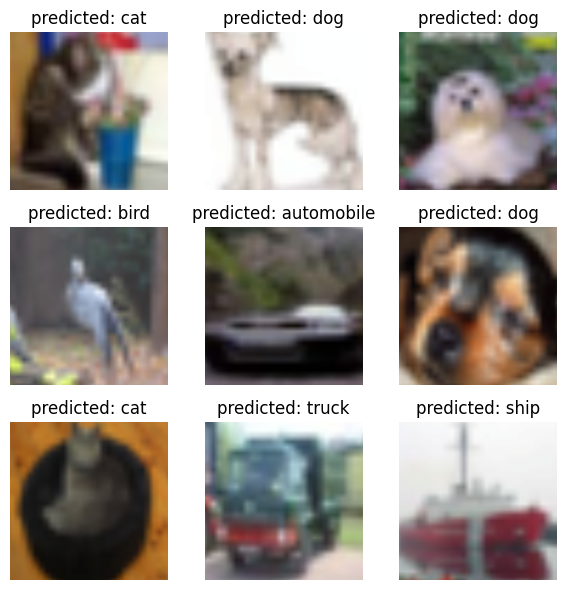

In [21]:
# Visualizing some predictions after fine-tuning on CIFAR10
visualize_model(new_model_ft, device=device)
plt.tight_layout()